In [1]:
import pandas as pd
import numpy as np
from random import random
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

In [2]:
# White alone refers to people who reported White and did not report any other race category. 
# Black alone refers to people who reported Black and did not report any other race category.
# Asian alone refers to people who reported Asian and did not report any other race category.
# Because Hispanics may be any race, data in this report for Hispanics overlap with data for racial groups. Being Hispanic was reported by 16.0 percent of White householders who reported only one race, 5.3 percent of Black householders who reported only one race, and 2.7 percent of Asian householders who reported only one race. 

# Data users should exercise caution when interpreting aggregate results for the Hispanic population and for race groups because these populations consist of many distinct groups that differ in socioeconomic characteristics, culture, and recency of immigration. Data were first collected for Hispanics in 1972.
# The use of this single-race population does not imply that it is the preferred method of presenting or analyzing the data. 
# The Census Bureau uses a variety of approaches.
# For the year 2001 and earlier, the CPS ASEC allowed respondents to report only one race group.
# so we only use data from 2002 to 2020 (the latest)

In [3]:
def read_data():
    # clean data
    # output two dictionaries 
    # race_income_dict: race, year, income distribution
    # race_num_dict: race, year, the number of households
    data=pd.read_excel('tableA2.xlsx', sheet_name='tableA2',header=4,nrows=360)
    data=data.drop(columns=['Total','Margin of error1 (±)','Margin of error1 (±).1'])
    data.columns=['year','number of households']+income_intervals+['median','mean']

    thisnull=0
    race_income_dict={}
    race_num_dict={}
    for i in data.index[1:]:
        lastnull=thisnull
        if sum(pd.isnull(data.loc[i])):
            thisnull=i
            race=has_numbers(data.loc[lastnull,'year'])
            if (data.loc[lastnull+1]['year']==2020) & (data.loc[thisnull-1]['year']<=year_start):
                #data.loc[thisnull-1]['year']
                range_used=[*range(lastnull+1,lastnull+5)]+[*range(lastnull+6,lastnull+10)]+[*range(lastnull+11,lastnull+22)] # remove repeated 2017 and 2013
                race_income_dict.update({race: data[['year']+income_intervals].loc[range_used]})
                race_num_dict.update({race: data[['year','number of households']].loc[range_used]})
        elif isinstance(data.loc[i,'year'], str):
            data.loc[i,'year']=int(data.loc[i,'year'][0:4])
    return race_income_dict, race_num_dict

def has_numbers(inputString):
    # used for data cleaning
    if any(char.isdigit() for char in inputString):
        output=inputString[:-3]
    else:
        output=inputString
    return output

def sample_income(race_name,year_name):
    # sample income for given race and year
    lo=[10,15,25,35,50,75,100,150,200]
    up=[15,25,35,50,75,100,150,200,300]
    race_group=race_income_dict[race_name]
    race_series=race_group[race_group['year']==year_name]
    percentiles=[race_series[i].tolist()[0] for i in income_intervals]
    chosen_interval=np.random.choice(range(len(income_intervals)), p=[p/sum(percentiles) for p in percentiles])
    chosen_income=random()*(up[chosen_interval]-lo[chosen_interval])+lo[chosen_interval]
    return round(chosen_income,2)

def sample_race(year_name,race_set):
    # sample race for given year
    percentiles=[]
    race_names=list(race_num_dict.keys())
    for race_name in race_set: #race_names[1:]:
        race_group=race_num_dict[race_name]
        percentiles+=race_group[race_group['year']==year_name]['number of households'].tolist()
    chosen_race=np.random.choice(race_set, p=[p/sum(percentiles) for p in percentiles])
    return chosen_race
from scipy.stats import norm
def sample_repay(income):
    # sample repay label for given income (1 for repay, 0 for default)
    # repay label 1: the client will repay if loan approved
    # using Gaussian conditional independence model
    # https://arxiv.org/pdf/1907.03044.pdf
    
    # two decision: 1 give 3.5*annual income quota; 0 reject;
    # assume client will use all quota once approved
    # assume annual interest 7.2%
    # assume basic living cost 15,000 dollar
    # if annual income - annual interest < 10,000, the client must default
    # iff annual income - annual interest >= 10,000, repay label is Bernoulli random variables, with p = annual interest/(income - annual interest)
    load_limit=3.5
    interest=0.0216
    living_cost=10
    z=(income-living_cost-income*load_limit*interest)/income #-living_cost
    if z<=0:
        repay=0
    else:
        p=norm.cdf(z*5)
        repay= 0 if (p<random()) else 1 # if p < 0 , repay=0 (no)
    return repay

def income2code(income):
    if income < 15:
        code=0
    else:
        code=1
    #elif income <200:
    #    code=int(income/50)+1
    #else:
    #    code=int(200/50)+1
    return code

def trial4(year_range,client_num,race_set):
    index_list=[item for sublist in [[str(y)+'_income',str(y)+'_code',str(y)+'_repay'] for y in year_range] for item in sublist]
    client_list=pd.DataFrame(columns=['race']+index_list)
    
    # generate a client_list
    # rows: client ID
    # columns: income, income class, repay label for years 2002-2020
    # repay label 1: the client will repay *if loan approved*
    for client in tqdm(range(client_num)):
        race=sample_race(year_start,race_set)
        income_dict={'race':race}
        for year_name in year_range:
            income_tem=sample_income(race,year_name)
            code_tem=income2code(income_tem) #int(income_tem/50)+1 if income_tem > 15 else 0
            repay=sample_repay(income_tem)
            income_dict.update({str(year_name)+'_income':income_tem,str(year_name)+'_code':code_tem,str(year_name)+'_repay':repay}) # 1000 dollars 
        client_list=client_list.append(income_dict,ignore_index=True)
    
    # initialise decision, result, avg_default
    # decision: 1 for approving load application
    # result: 1 for loan approved and repaid
    # avg_default: sum of result since 2002 / sum of decision since 2002
    for i in range(2): #np.random.randint(0,2,(1,client_num)).tolist()[0]
        client_list.insert(0, str(year_range[i])+'_decision',1) # initial decision: random var or approve all loans in 2002
        client_list.insert(0, str(year_range[i])+'_result', client_list[str(year_range[i])+'_decision']*client_list[str(year_range[i])+'_repay'])
        client_list.insert(0, str(year_range[i])+'_avg_default', 1-client_list[str(year_range[i])+'_result'])
    
    # logistic regression used to decide loan approval
    for year_name in year_range[2:]:
        #print(year_name)
        attributes_train=pd.concat([client_list[str(year_name-2)+'_avg_default'],pd.get_dummies(client_list[str(year_name-1)+'_code'])],axis=1)
        #if year_name==2003:
        attributes=pd.concat([client_list[str(year_name-1)+'_avg_default'],pd.get_dummies(client_list[str(year_name)+'_code'])],axis=1)
        #else:
        #    attributes=pd.concat([client_list[str(year_name)+'_avg_default'],pd.get_dummies(client_list[str(year_name)+'_code'])],axis=1)
        x_train=np.array(attributes_train).tolist()#np.array(pd.get_dummies(client_list[str(year_name)+'_code'])).tolist() #np.array(client_list[str(2002)+'_code'].tolist()).reshape(-1, 1)
        x=np.array(attributes).tolist()
        y=np.array(client_list[str(year_name-1)+'_result'].tolist())
        #param=logisticRegression(x_train, y, lamb=1.0)
        repay_predict=predict(x,logisticRegression(x_train, y, lamb=0))
        client_list.insert(0, str(year_name)+'_decision',repay_predict) #[int(repay_proba[i,1]>threshold) for i in range(len(repay_proba))]
        client_list.insert(0, str(year_name)+'_result', client_list[str(year_name)+'_decision']*client_list[str(year_name)+'_repay'])    
        # result: 1 good record
        # update avg_default
        #if year_name > 2003:
        decision_cols=[str(y)+'_decision' for y in range(year_range[0],year_name+1)] # 1: approved load
        approved_times=client_list[decision_cols].apply(np.sum, axis=1)
        result_cols=[str(y)+'_result' for y in range(year_range[0],year_name+1)] # 1 : approved load and repay
        repay_times=client_list[result_cols].apply(np.sum, axis=1)
        client_list.insert(0, str(year_name)+'_avg_default', 1-repay_times/approved_times)
        #else:
        #    client_list.insert(0, '2003_avg_default', 1-client_list['2003_result']/client_list['2003_decision'])
        #model.intercept_ #model.coef_ #model.predict(x)

    return client_list.iloc[:,:len(year_range)*3+1]

def group_metric(client_list):
    # group performance of avg_default
    sub_client_list=pd.DataFrame(columns=perf_list)
    for race_name in set(client_list.race):
        race_default={'race':race_name}
        race_list=client_list[client_list['race']==race_name]
        for year_name in year_range:
            decision_cols=[str(year_name)+'_decision' for year_name in range(year_start,year_name+1)] # 1: approved load
            approved_times=sum(race_list[decision_cols].apply(np.sum, axis=1))
            result_cols=[str(year_name)+'_result' for year_name in range(year_start,year_name+1)] # 1 : approved load and repay
            repay_times=sum(race_list[result_cols].apply(np.sum, axis=1))
            if repay_times==0: # alter when nobody in a certain race in a year gets approved
                print('approved_times ',approved_times)
                print('race ',race_name)
                print('year ',year_name)
            race_default.update({str(year_name)+'_avg_default':1-repay_times/(approved_times+0.01)})

        sub_client_list=sub_client_list.append(race_default,ignore_index=True)
    return sub_client_list

In [4]:
inf=10

import mosek

def softplus(task, t, u, n):
    nvar = task.getnumvar()
    ncon = task.getnumcon()
    task.appendvars(6*n)
    task.appendcons(3*n)
    z1, z2, v1, v2, q1, q2 = nvar, nvar+n, nvar+2*n, nvar+3*n, nvar+4*n, nvar+5*n
    zcon, v1con, v2con = ncon, ncon+n, ncon+2*n

    # z1 + z2 = 1
    task.putaijlist(range(zcon, zcon+n), range(z1, z1+n), [1]*n)
    task.putaijlist(range(zcon, zcon+n), range(z2, z2+n), [1]*n)
    # u - t - v1 = 0
    task.putaijlist(range(v1con, v1con+n), range(u, u+n), [1]*n)
    task.putaijlist(range(v1con, v1con+n), range(t, t+n), [-1]*n)
    task.putaijlist(range(v1con, v1con+n), range(v1, v1+n), [-1]*n)
    # - t - v2 = 0
    task.putaijlist(range(v2con, v2con+n), range(t, t+n), [-1]*n)
    task.putaijlist(range(v2con, v2con+n), range(v2, v2+n), [-1]*n)
    # Bounds for all constraints
    task.putconboundslice(ncon, ncon+3*n, [mosek.boundkey.fx]*(3*n), [1]*n+[0]*(2*n), [1]*n+[0]*(2*n))
    # Bounds for variables
    task.putvarboundsliceconst(nvar, nvar+4*n, mosek.boundkey.fr, -inf, inf)
    task.putvarboundsliceconst(nvar+4*n, nvar+6*n, mosek.boundkey.fx, 1, 1)

    # Cones
    for i in range(n):
        task.appendcone(mosek.conetype.pexp, 0.0, [z1+i, q1+i, v1+i])
        task.appendcone(mosek.conetype.pexp, 0.0, [z2+i, q2+i, v2+i])
    
def logisticRegression(x, y, lamb=0.5):
    X=np.array(x)
    n, d = int(X.shape[0]), int(X.shape[1])         # num samples, dimension
    print('n,d: ',n,', ',d)
    env  = mosek.Env()
    task = env.Task(0,0)
    
    # Variables [r; theta; t; u]
    nvar = 1+d+2*n
    task.appendvars(nvar)
    task.putvarboundsliceconst(0, nvar, mosek.boundkey.ra, -inf, inf)
    r, theta, t, u, = 0, 1, 1+d, 1+d+n
    
    task.putvarbound(theta,mosek.boundkey.ra, -inf, 0)
    task.putvarbound(theta+1,mosek.boundkey.ra, 0, inf)
    
    # Constraints: theta'*X +/- u = 0
    task.appendcons(n)
    task.putconboundsliceconst(0, n, mosek.boundkey.fx, 0.0, 0.0)  
    
    ncon = task.getnumcon()
    task.appendcons(d-2)
    for i in range(d-2):
        task.putarow(ncon+i, [theta+i+1,theta+i+2],[-1.0,1.0])
    task.putconboundslice(ncon, ncon+d-2, [mosek.boundkey.ra]*(d-2), [0]*(d-2), [10]*(d-2))

    # Objective lambda*r + sum(t)
    task.putcj(r, lamb)
    task.putclist(range(t, t+n), [1.0]*n)

    # The X block in theta'*X +/- u = 0
    uCoeff = []
    for i in range(n):
        task.putaijlist([i]*d, range(theta, theta+d), X[i])
        uCoeff.append(1 if y[i] == 1 else -1)
    # +/- coefficients in u depending on y
    task.putaijlist(range(n), range(u, u+n), uCoeff)

    # Softplus function constraints
    softplus(task, t, u, n)

    # Regularization
    task.appendconeseq(mosek.conetype.quad, 0.0, 1+d, r)

    # Solution
    task.optimize()
    print(task.getsolsta(mosek.soltype.itr))
    xx = [0.0]*d
    task.getxxslice(mosek.soltype.itr, theta, theta+d, xx)

    return xx # parameters

def predict(x,param):
    thetax=np.dot(np.array(x),np.array(param))
    y_predict=sigmoid(thetax)
    #print('x_predict:',x)
    #print('y_predict:',y_predict)
    print('param:',param)
    y_predict[y_predict > 0.6] = 1
    y_predict[y_predict <= 0.6] = 0
    return y_predict # np.sum(np.abs(scores - labels)) / float(np.size(labels))

def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [60]:
year_start=2002
year_end=2020
year_range=[*range(year_start,year_end+1)]

#race_range=race_names[1:]
race_range=['BLACK ALONE','WHITE ALONE','ASIAN ALONE']

income_intervals=['under 15','15-25','25-35','35-50','50-75','75-100','100-150','150-200','over 200']

client_num=1000
perf_list=['race']+[str(y)+'_avg_default' for y in year_range]

trial_range=[*range(5)]

race_income_dict, race_num_dict=read_data()
group_perf=pd.DataFrame(columns=perf_list+['Trial'])
indiv_perf=pd.DataFrame(columns=perf_list+['Trial'])

for trial in trial_range:

    client_ts=trial4(year_range,client_num,race_range)

    group_perf_tem=group_metric(client_ts) # client ID, avg_default
    group_perf_tem['Trial']=trial

    indiv_perf_tem=client_ts[perf_list] # race, avg default
    indiv_perf_tem['Trial']=trial
    
    group_perf=pd.concat([group_perf, group_perf_tem], ignore_index=True)
    indiv_perf=pd.concat([indiv_perf, indiv_perf_tem], ignore_index=True)
    
group_perf.to_csv('group_perf.csv',index=False)
indiv_perf.to_csv('indiv_perf.csv',index=False)

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.79it/s]


n,d:  1000 ,  3
solsta.optimal
param: [-5.575942275933299e-10, 0.5634614772871493, 5.698145765601131]
n,d:  1000 ,  3
solsta.optimal
param: [-4.755978607777811e-09, 0.8109183976513263, 6.102743706747147]
n,d:  1000 ,  3
solsta.optimal
param: [-0.4998325843984507, 0.41424554492897075, 5.719169001665298]
n,d:  1000 ,  3
solsta.optimal
param: [-7.564615002598924, 0.1570315349735547, 6.1602415840288165]
n,d:  1000 ,  3
solsta.optimal
param: [-7.971065354841488, -1.3754752702458955e-10, 6.03838695190603]
n,d:  1000 ,  3
solsta.optimal
param: [-7.830344387653793, -2.913981495422444e-10, 6.219783488659029]
n,d:  1000 ,  3
solsta.optimal
param: [-7.95737155528047, -6.987201036403479e-11, 6.056421177357472]
n,d:  1000 ,  3
solsta.optimal
param: [-7.508803265051502, -7.380774016545757e-11, 6.604382899089114]
n,d:  1000 ,  3
solsta.optimal
param: [-8.411501333065702, -5.3078072235241246e-11, 5.408016745352203]
n,d:  1000 ,  3
solsta.optimal
param: [-7.565797574687194, -1.1632578970916353e-11, 6.5

<ipython-input-60-4c237ca555c3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  indiv_perf_tem['Trial']=trial
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.92it/s]


n,d:  1000 ,  3
solsta.optimal
param: [-0.05068572157692313, 0.5493756763201824, 5.713382382478126]
n,d:  1000 ,  3
solsta.optimal
param: [-0.5176072457566484, 0.5762592379797825, 6.8176457476380525]
n,d:  1000 ,  3
solsta.optimal
param: [-6.06602142623546, 0.3145516800355197, 6.047605451938738]
n,d:  1000 ,  3
solsta.optimal
param: [-7.043938732437425, -1.4494349959011293e-10, 6.807276633494164]
n,d:  1000 ,  3
solsta.optimal
param: [-8.249537589322992, -1.5692644180649172e-10, 5.634753990308529]
n,d:  1000 ,  3
solsta.optimal
param: [-7.6947703754233325, -6.685159341301304e-11, 6.386744762081146]
n,d:  1000 ,  3
solsta.optimal
param: [-8.331446291271027, -5.226542628237303e-11, 5.530551727319204]
n,d:  1000 ,  3
solsta.optimal
param: [-7.8145277138815805, -1.6875473027318393e-10, 6.239643887240249]
n,d:  1000 ,  3
solsta.optimal
param: [-7.892292303341091, -1.6411323020699234e-10, 6.140987010638935]
n,d:  1000 ,  3
solsta.optimal
param: [-8.130612765389966, -5.962199360677346e-11, 5.

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 30.65it/s]


n,d:  1000 ,  3
solsta.optimal
param: [-1.6565042482017928e-09, 0.4452894099473297, 6.101220854508667]
n,d:  1000 ,  3
solsta.optimal
param: [-6.375428416961257e-10, 0.5737845387856938, 4.991722483027586]
n,d:  1000 ,  3
solsta.optimal
param: [-3.375438725289548, 0.3525762756532127, 5.955303397175196]
n,d:  1000 ,  3
solsta.optimal
param: [-7.563649391054651, -1.8578981575488933e-10, 6.5414988936863425]
n,d:  1000 ,  3
solsta.optimal
param: [-7.762673456286923, -2.0394219124433887e-10, 6.304038443004525]
n,d:  1000 ,  3
solsta.optimal
param: [-6.419315771134721, -7.412157997084741e-11, 7.667619253442318]
n,d:  1000 ,  3
solsta.optimal
param: [-7.89391322152496, -2.6788042530224103e-10, 6.138903301675575]
n,d:  1000 ,  3
solsta.optimal
param: [-8.520473058203306, -1.9779026757776457e-10, 5.234647886631916]
n,d:  1000 ,  3
solsta.optimal
param: [-8.414269819240555, -6.220320470529417e-11, 5.403708297282781]
n,d:  1000 ,  3
solsta.optimal
param: [-8.52816179175836, -5.018883530186403e-11,

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.72it/s]


n,d:  1000 ,  3
solsta.optimal
param: [-0.08591262945585544, 0.5796945513234014, 5.703561525193619]
n,d:  1000 ,  3
solsta.optimal
param: [-1.1300316307750237e-09, 0.5108171955287217, 5.704757543486799]
n,d:  1000 ,  3
solsta.optimal
param: [-5.2107315216724306e-09, 0.32088926358325537, 6.120488158569274]
n,d:  1000 ,  3
solsta.optimal
param: [-6.861462334838951, -1.7727567804760306e-10, 6.750903209639112]
n,d:  1000 ,  3
solsta.optimal
param: [-7.528536571941965, -1.8183686410447652e-10, 6.5818794287736955]
n,d:  1000 ,  3
solsta.optimal
param: [-8.301333078619791, -9.070331913676079e-11, 5.575649653638227]
n,d:  1000 ,  3
solsta.optimal
param: [-8.01125128269992, -2.791975379152827e-10, 5.984968888482527]
n,d:  1000 ,  3
solsta.optimal
param: [-7.335048366131585, -6.195576485007401e-11, 6.796842274796064]
n,d:  1000 ,  3
solsta.optimal
param: [-8.430848564436424, -5.394023171179302e-11, 5.377805523620019]
n,d:  1000 ,  3
solsta.optimal
param: [-8.327093575900372, -7.135091529060882e-

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.76it/s]


n,d:  1000 ,  3
solsta.optimal
param: [-9.189959830933655e-10, 0.2696620083954906, 5.703781074880955]
n,d:  1000 ,  3
solsta.optimal
param: [-2.4527960954518493, -3.777717763161897e-10, 5.527584634119259]
n,d:  1000 ,  3
solsta.optimal
param: [-5.133030830011403, -5.12493574436584e-11, 5.839568676033873]
n,d:  1000 ,  3
solsta.optimal
param: [-4.827321726844962, -8.749056218149353e-11, 5.687149033485883]
n,d:  1000 ,  3
solsta.optimal
param: [-6.640885603051089, -1.4696961894681893e-10, 5.522859398620445]
n,d:  1000 ,  3
solsta.optimal
param: [-8.172825141496206, -4.499347870071693e-11, 5.762371836073655]
n,d:  1000 ,  3
solsta.optimal
param: [-7.425754646361246, -1.1685173876799315e-10, 6.697624027602889]
n,d:  1000 ,  3
solsta.optimal
param: [-7.8298319499398525, -1.4672067569556524e-10, 6.220428525711055]
n,d:  1000 ,  3
solsta.optimal
param: [-7.989943591715653, -1.1713639191557152e-10, 6.013385180861435]
n,d:  1000 ,  3
solsta.optimal
param: [-8.490025085502644, -9.62537788599215e

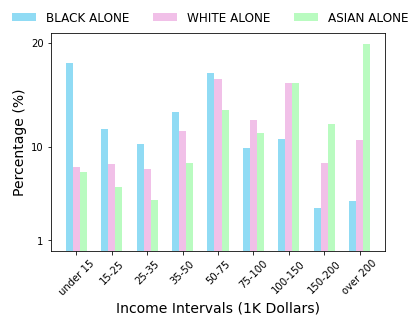

In [51]:
#y=[]
bar_width=0.2
j=-1
for race_name in race_range:
    y=[race_income_dict[race_name][race_income_dict[race_name]['year']==2020][i].values[0] for i in income_intervals]
    x=[i+j*bar_width for i in range(len(income_intervals))]
    #income_intervals
    plt.bar(x, y, bar_width, color=pal[race_name],label=race_name)
    j+=1

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
    
plt.xticks([*range(9)],labels=income_intervals,rotation=45)
plt.xlabel('Income Intervals (1K Dollars)',fontsize=14)
plt.yticks([1,10,20])
plt.ylabel('Percentage (%)',fontsize=14)
plt.legend(bbox_to_anchor=(1.1,1.15), fontsize=12,frameon=False,ncol=3)

plt.savefig("precentage_distribution.pdf",bbox_inches='tight')

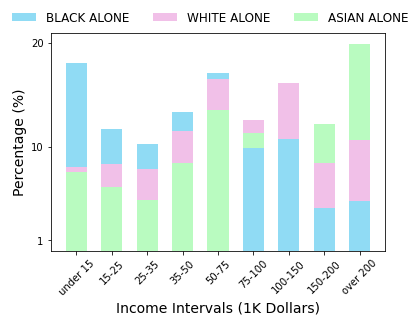

In [8]:
year_start=2002
year_end=2020
year_range=[*range(year_start,year_end+1)]

#race_range=race_names[1:]
race_range=['BLACK ALONE','WHITE ALONE','ASIAN ALONE']

income_intervals=['under 15','15-25','25-35','35-50','50-75','75-100','100-150','150-200','over 200']

client_num=1000

race_income_dict=read_data()[0]
colors=['#90DBF4','#F1C0E8','#B9FBC0','#3D405B'] ##A3B18A #B9FBC0
#colors=['#DEE2FF','#CBC0D3','#EFD3D7']
pal=dict(zip(race_range,colors[:len(race_range)]))

bar_width = 0.6
i=0
for interval in income_intervals:
    column=[race_income_dict[race_name][race_income_dict[race_name]['year']==2020][interval].values[0] for race_name in race_range]
    rank=np.argsort(column)[::-1]
    ylist=sorted(column,reverse=True)
    #print(ylist)
    #print([race_range[r] for r in list(rank)])
    colors=[pal[race_range[r]] for r in list(rank)]
    #print(colors)
    if interval=='100-150':
        
    elif i == 0 :
        race_list=[race_range[r] for r in list(rank)]
        for j in range(3):
            plt.bar(i, ylist[j], bar_width, color=colors[j],label=race_list[j])
    else:
        for j in range(3):
            plt.bar(i, ylist[j], bar_width, color=colors[j])
    i+=1
    
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
    
plt.xticks([*range(9)],labels=income_intervals,rotation=45)
plt.xlabel('Income Intervals (1K Dollars)',fontsize=14)
plt.yticks([1,10,20])
plt.ylabel('Percentage (%)',fontsize=14)
plt.legend(bbox_to_anchor=(1.1,1.15), fontsize=12,frameon=False,ncol=3)
#plt.savefig("precentage_distribution.pdf",bbox_inches='tight')

In [10]:
[race_income_dict[race_name][race_income_dict[race_name]['year']==2020]['100-150'].values[0] for race_name in race_range]

[10.7, 16.1, 16.1]

In [149]:
year_start=2002
year_end=2020
year_range=[*range(year_start,year_end+1)]

#race_range=race_names[1:]
race_range=['BLACK ALONE','WHITE ALONE','ASIAN ALONE']

income_intervals=['under 15','15-25','25-35','35-50','50-75','75-100','100-150','150-200','over 200']

client_num=1000
#threshold=0.5 # threshold for estimating repay
perf_list=['race']+[str(y)+'_avg_default' for y in year_range]

race_income_dict, race_num_dict=read_data()
client_ts=trial4(year_range,client_num,threshold,race_range)

group_perf=group_metric(client_ts) # client ID, avg_default
indiv_perf=client_ts[perf_list] # race, avg default

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 34.78it/s]


n,d:  1000 ,  7
solsta.optimal
param: [-0.00940810377332572, -4.682073967891271, -0.45834717083225457, 0.8954523588443917, 1.4615037485936706, 1.8400955015309952, 2.334992983492947]
n,d:  1000 ,  7
solsta.optimal
param: [-0.25234137640825677, -5.644222514986571, -5.6442225149430705, 1.0650108307096398, 1.5745876414212836, 1.5936145448026333, 2.3778122248315507]
n,d:  1000 ,  7
solsta.optimal
param: [-0.37342043604066066, -5.65715091400283, -5.65715091310917, 1.1340964904021098, 1.7202255396754198, 1.720225539571547, 2.4812754874676433]
n,d:  1000 ,  7
solsta.optimal
param: [-0.19229227595839674, -5.684461678873766, -5.68446167822149, 0.7557520148386402, 1.41187446612444, 1.4118744661253424, 1.4621173322470484]
n,d:  1000 ,  7
solsta.optimal
param: [-0.029095791198203918, -5.675882819501077, -5.67588281768977, 0.9380134869166431, 1.4785831678176289, 1.867781027589966, 1.8677810427852144]
n,d:  1000 ,  7
solsta.optimal
param: [-0.4439257148232228, -5.6384298896819685, -5.638429885773992,

In [48]:
indiv_perf

,race,2002_avg_default,2003_avg_default,2004_avg_default,2005_avg_default,2006_avg_default,2007_avg_default,2008_avg_default,2009_avg_default,2010_avg_default,...,2012_avg_default,2013_avg_default,2014_avg_default,2015_avg_default,2016_avg_default,2017_avg_default,2018_avg_default,2019_avg_default,2020_avg_default,Trial
0,WHITE ALONE,1,1.0,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
1,WHITE ALONE,0,0.0,0.000000,0.25,0.20,0.166667,0.142857,0.142857,0.142857,...,0.111111,0.100000,0.090909,0.083333,0.076923,0.142857,0.133333,0.125000,0.125000,0
2,WHITE ALONE,1,1.0,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
3,WHITE ALONE,0,0.0,0.333333,0.25,0.25,0.400000,0.400000,0.333333,0.285714,...,0.285714,0.285714,0.285714,0.285714,0.375000,0.333333,0.300000,0.300000,0.300000,0
4,WHITE ALONE,1,1.0,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,WHITE ALONE,0,0.0,0.000000,0.25,0.20,0.200000,0.166667,0.166667,0.166667,...,0.142857,0.125000,0.125000,0.125000,0.111111,0.111111,0.111111,0.111111,0.100000,2
1496,WHITE ALONE,0,0.0,0.000000,0.25,0.20,0.200000,0.166667,0.285714,0.250000,...,0.250000,0.222222,0.222222,0.200000,0.200000,0.181818,0.250000,0.230769,0.230769,2
1497,WHITE ALONE,1,1.0,1.000000,1.00,1.00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2
1498,WHITE ALONE,0,0.0,0.000000,0.00,0.20,0.333333,0.333333,0.333333,0.333333,...,0.285714,0.250000,0.250000,0.222222,0.222222,0.300000,0.272727,0.250000,0.250000,2


In [151]:
group_perf

,race,2002_avg_default,2003_avg_default,2004_avg_default,2005_avg_default,2006_avg_default,2007_avg_default,2008_avg_default,2009_avg_default,2010_avg_default,2011_avg_default,2012_avg_default,2013_avg_default,2014_avg_default,2015_avg_default,2016_avg_default,2017_avg_default,2018_avg_default,2019_avg_default,2020_avg_default
0,BLACK ALONE,0.431696,0.474839,0.434149,0.404595,0.388534,0.357705,0.345626,0.343510,0.343338,0.338898,0.334649,0.336582,0.332582,0.328049,0.323038,0.321705,0.315562,0.307956,0.302147
1,WHITE ALONE,0.426513,0.408437,0.364476,0.335580,0.325239,0.313366,0.307822,0.298714,0.288440,0.281407,0.276388,0.273155,0.270374,0.265897,0.264136,0.261216,0.258982,0.258138,0.256626
2,ASIAN ALONE,0.484037,0.371069,0.325660,0.311386,0.314571,0.268505,0.251506,0.241065,0.250035,0.240538,0.238311,0.238295,0.246601,0.248451,0.241910,0.239690,0.231382,0.222779,0.219697


# The End

In [ ]:
def info2decision(info):
    # info 2 info_code
    time_in_address,income=info #,existing_client
    duration_code=int(np.floor(time_in_address/36)) if time_in_address<108 else 3
    if income < 30:
        income_code=0
    elif income < 60:
        income_code=1
    elif income < 100:
        income_code=2
    else:
        income_code=3
    #exist_code=existing_client
    
    # info_code 2 score
    intercept,duration_scores,income_scores,decision_thresholds=param.values() #,exist_scores
    score=intercept+duration_scores[duration_code]+income_scores[income_code] #+exist_scores*exist_code
    
    # score 2 decision_code
    # 0: reject;
    # 1: Refer to specialist
    # 2: Offer 7.2% for up to £10000
    # 3: 8.2% up to £10000
    decision_code=sum([i<score for i in decision_thresholds])
    
    return decision_code

In [3]:
def trial(year_range,client_num):
    # two decision: 1 give 3.5*annual income quota; 0 reject;
    # assume client will use all quota once approved
    # assume annual interest 7.2%
    # assume basic living cost 10,000 dollar
    # if annual income - annual interest < 10,000, the client must default
    # iff annual income - annual interest >= 10,000, repay(0) is Bernoulli random variables, with p = annual interest/(income - annual interest)
    index_list=[item for sublist in [[str(y)+'_income',str(y)+'_code',str(y)+'_repay'] for y in year_range] for item in sublist]
    client_list=pd.DataFrame(columns=['race']+index_list)
    
    for client in range(client_num):
        race=sample_race(year_start)
        #for year_name in range(2002,2021):
        #time_in_address=random()*(100) # months
        #existing_client=1 #round(random()) # 1 if existing client

        #info=[time_in_address,income]
        #decision_code=info2decision(info) # scorecard
        #income=[]
        income_dict={'race':race}
        for year_name in year_range:
            income_tem=sample_income(race,year_name)
            code_tem=int(income_tem/50)+1 if income_tem > 15 else 0
            repay=sample_repay(income_tem)
            income_dict.update({str(year_name)+'_income':income_tem,str(year_name)+'_code':code_tem,str(year_name)+'_repay':repay}) # 1000 dollars
            #income+=sample_income(race,year_name)  
        client_list=client_list.append(income_dict,ignore_index=True) #,'decision':decision_code

    for year_name in year_range:
        x=np.array(pd.get_dummies(client_list[str(year_name)+'_code'])).tolist() #np.array(client_list[str(2002)+'_code'].tolist()).reshape(-1, 1)
        y=np.array(client_list[str(year_name)+'_repay'].tolist())
        model = LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x, y)
        client_list.insert(0, str(year_name)+'_decision', model.predict(x))
        client_list.insert(0, str(year_name)+'_result', client_list[str(year_name)+'_decision']*client_list[str(year_name)+'_repay'])
        #model.intercept_ #model.coef_ #model.predict(x)

    return client_list.iloc[:,:len(year_range)*2+1]


def individual_metric(client_list):
    rep_client_list=client_list.copy()
    for year_name in year_range:
        decision_cols=[str(year_name)+'_decision' for year_name in range(year_start,year_name+1)] # 1: approved load
        approved_times=client_list[decision_cols].apply(np.sum, axis=1)
        result_cols=[str(year_name)+'_result' for year_name in range(year_start,year_name+1)] # 1 : approved load and repay
        repay_times=client_list[result_cols].apply(np.sum, axis=1)

        rep_client_list.insert(0, str(year_name)+'_avg_default', 1-repay_times/approved_times)

    return rep_client_list[perf_list]

def trial2(year_range,client_num,threshold,race_set):
    index_list=[item for sublist in [[str(y)+'_income',str(y)+'_code',str(y)+'_repay'] for y in year_range] for item in sublist]
    client_list=pd.DataFrame(columns=['race']+index_list)
    
    # generate a client_list
    # rows: client ID
    # columns: income, income class, repay label for years 2002-2020
    # repay label 1: the client will repay *if loan approved*
    for client in tqdm(range(client_num)):
        race=sample_race(year_start,race_set)
        income_dict={'race':race}
        for year_name in year_range:
            income_tem=sample_income(race,year_name)
            code_tem=income2code(income_tem) #int(income_tem/50)+1 if income_tem > 15 else 0
            repay=sample_repay(income_tem)
            income_dict.update({str(year_name)+'_income':income_tem,str(year_name)+'_code':code_tem,str(year_name)+'_repay':repay}) # 1000 dollars 
        client_list=client_list.append(income_dict,ignore_index=True)
    
    # initialise decision, result, avg_default
    # decision: 1 for approving load application
    # result: 1 for loan approved and repaid
    # avg_default: sum of result since 2002 / sum of decision since 2002
    client_list.insert(0, str(year_range[0])+'_decision', np.random.randint(0,2,(1,client_num)).tolist()[0] ) # initial decision: random var or approve all loans in 2002
    client_list.insert(0, str(year_range[0])+'_result', client_list[str(year_range[0])+'_decision']*client_list[str(year_range[0])+'_repay'])
    client_list.insert(0, str(year_range[0])+'_avg_default', 1-client_list[str(year_range[0])+'_result'])
    
    # logistic regression used to decide loan approval
    for year_name in year_range[1:]:
        #print(year_name)
        attributes=pd.concat([client_list[str(year_name-1)+'_result'],pd.get_dummies(client_list[str(year_name)+'_code'])],axis=1)
        x=np.array(attributes).tolist()#np.array(pd.get_dummies(client_list[str(year_name)+'_code'])).tolist() #np.array(client_list[str(2002)+'_code'].tolist()).reshape(-1, 1)
        y=np.array(client_list[str(year_name)+'_repay'].tolist())
        model=LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x, y)
        repay_proba=model.predict_proba(x)
        print('year: ',year_name)
        print('intercept: ',model.intercept_)
        print('coef: ',model.coef_)
        # approve load only when repay_proba ? threshold(0.7)
        client_list.insert(0, str(year_name)+'_decision',[int(repay_proba[i,1]>threshold) for i in range(len(repay_proba))])
        client_list.insert(0, str(year_name)+'_result', client_list[str(year_name)+'_decision']*client_list[str(year_name)+'_repay'])    
        # result: 1 good record
        # update avg_default
        decision_cols=[str(y)+'_decision' for y in range(year_start,year_name+1)] # 1: approved load
        approved_times=client_list[decision_cols].apply(np.sum, axis=1)
        result_cols=[str(y)+'_result' for y in range(year_start,year_name+1)] # 1 : approved load and repay
        repay_times=client_list[result_cols].apply(np.sum, axis=1)
        client_list.insert(0, str(year_name)+'_avg_default', 1-repay_times/approved_times)
        #model.intercept_ #model.coef_ #model.predict(x)

    return client_list.iloc[:,:len(year_range)*3+1]


def trial3(year_range,client_num,threshold,race_set):
    index_list=[item for sublist in [[str(y)+'_income',str(y)+'_code',str(y)+'_repay'] for y in year_range] for item in sublist]
    client_list=pd.DataFrame(columns=['race']+index_list)
    
    # generate a client_list
    # rows: client ID
    # columns: income, income class, repay label for years 2002-2020
    # repay label 1: the client will repay *if loan approved*
    for client in tqdm(range(client_num)):
        race=sample_race(year_start,race_set)
        income_dict={'race':race}
        for year_name in year_range:
            income_tem=sample_income(race,year_name)
            code_tem=income2code(income_tem) #int(income_tem/50)+1 if income_tem > 15 else 0
            repay=sample_repay(income_tem)
            income_dict.update({str(year_name)+'_income':income_tem,str(year_name)+'_code':code_tem,str(year_name)+'_repay':repay}) # 1000 dollars 
        client_list=client_list.append(income_dict,ignore_index=True)
    
    # initialise decision, result, avg_default
    # decision: 1 for approving load application
    # result: 1 for loan approved and repaid
    # avg_default: sum of result since 2002 / sum of decision since 2002
    for i in range(2): #np.random.randint(0,2,(1,client_num)).tolist()[0]
        client_list.insert(0, str(year_range[i])+'_decision',1) # initial decision: random var or approve all loans in 2002
        client_list.insert(0, str(year_range[i])+'_result', client_list[str(year_range[i])+'_decision']*client_list[str(year_range[i])+'_repay'])
        client_list.insert(0, str(year_range[i])+'_avg_default', 1-client_list[str(year_range[i])+'_result'])
    
    # logistic regression used to decide loan approval
    for year_name in year_range[2:]:
        #print(year_name)
        attributes_train=pd.concat([client_list[str(year_name-2)+'_result'],pd.get_dummies(client_list[str(year_name-1)+'_code'])],axis=1)
        attributes=pd.concat([client_list[str(year_name-1)+'_result'],pd.get_dummies(client_list[str(year_name)+'_code'])],axis=1)
        x_train=np.array(attributes_train).tolist()#np.array(pd.get_dummies(client_list[str(year_name)+'_code'])).tolist() #np.array(client_list[str(2002)+'_code'].tolist()).reshape(-1, 1)
        x=np.array(attributes).tolist()
        y=np.array(client_list[str(year_name-1)+'_result'].tolist())
        
        model=LogisticRegression(solver='liblinear', random_state=0)
        model.fit(x_train, y)
        repay_proba=model.predict_proba(x)
        repay_tem=[int(repay_proba[i,1]>threshold) for i in range(len(repay_proba))]
        print('year: ',year_name)
        print('intercept: ',model.intercept_)
        print('coef: ',model.coef_)
        #repay=LogRegreesion(x_train,y,x)
        # approve load only when repay_proba ? threshold(0.7)
        client_list.insert(0, str(year_name)+'_decision',repay_tem) #[int(repay_proba[i,1]>threshold) for i in range(len(repay_proba))]
        client_list.insert(0, str(year_name)+'_result', client_list[str(year_name)+'_decision']*client_list[str(year_name)+'_repay'])    
        # result: 1 good record
        # update avg_default
        decision_cols=[str(y)+'_decision' for y in range(year_start,year_name+1)] # 1: approved load
        approved_times=client_list[decision_cols].apply(np.sum, axis=1)
        result_cols=[str(y)+'_result' for y in range(year_start,year_name+1)] # 1 : approved load and repay
        repay_times=client_list[result_cols].apply(np.sum, axis=1)
        client_list.insert(0, str(year_name)+'_avg_default', 1-repay_times/approved_times)
        #model.intercept_ #model.coef_ #model.predict(x)

    return client_list.iloc[:,:len(year_range)*3+1]


In [118]:
import cvxpy as cp

def sigmoid(z):
    return 1/(1 + np.exp(-z))

def LogRegreesion(x,y,x_test):
    X=np.array([[1]+x[i] for i in range(len(x))])
    m,n=X.shape # m clients, n attributes
    Y=np.array(y)
    beta = cp.Variable(n)
    log_likelihood = cp.sum(
        cp.multiply(Y, X @ beta) - cp.logistic(X @ beta)
    )
    constraint = [beta[1]>=0]+[beta[i]<=beta[i+1] for i in range(2,n-1)]
    problem = cp.Problem(cp.Maximize(log_likelihood/m-0.01* cp.norm(beta, 1)),constraint)
    problem.solve()
    X_test=np.array([[1]+x_test[i] for i in range(len(x_test))])
    print(X.shape)
    print(X_test.shape)
    Y_predict = predict( ( X_test @ beta).value)
   # test_error[i] = predict( (X_test @ beta[1:] +beta[0]).value, Y_test)

    #print('year: ',year_name)
    print('intercept: ',beta[0].value)
    print('coef: ',beta[1:].value)
    
    return Y_predict